# How to Detect Random Walk and White Noise in Time Series Forecasting
## and how to deal with them if you find one   ## TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@pripicart?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Tobi</a>
        on 
        <a href='https://www.pexels.com/photo/person-stands-on-brown-pathway-631986/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

## Setup

In [39]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")

warnings.filterwarnings("ignore")

In [2]:
tps_july = pd.read_csv(
    "https://raw.githubusercontent.com/BexTuychiev/medium_stories/master/2021/july/4_advanced_ts_visuals/data/tps_july_train.csv",
    parse_dates=["date_time"],
    index_col="date_time",
)

## Introduction

No matter how powerful, machine learning *cannot* predict everything. A well-known area where it can become pretty helpless is related to time series forecasting.

Despite the availability of a large suite of autoregressive models and many other algorithms for time series, you cannot predict the target distribution if it is **white noise** or follows a **random walk**. 

So, it is essential you detect such distributions before you make further efforts. 

In this article, you will learn what white noise and random walk are and explore proven statistical techniques to detect them.

## Before we start...

This is my third article on time series forecasting series (you check out the whole series from this [list](https://ibexorigin.medium.com/list/time-series-forecast-from-scratch-c72ccf7a9229), it is a new Medium feature).

While the first one was about every single Pandas function to manipulate TS data, the second one was about time series decomposition and autocorrelation. 

To get the most out of this post, you need to at least understand what autocorrelation is. Here, I will give a brief explanation but if you want to go deeper, check out my last article.

## 1. Brief notes on Autocorrelation

Autocorrelation involves finding the correlation between a time series and a lagged version of itself. Consider this distribution:

In [3]:
deg_C = tps_july["deg_C"].to_frame("temperature")

deg_C.head()

,temperature
date_time,
2010-03-10 18:00:00,13.1
2010-03-10 19:00:00,13.2
2010-03-10 20:00:00,12.6
2010-03-10 21:00:00,11.0
2010-03-10 22:00:00,11.9


Lagging a time series means shifting it 1 or more periods backward:

In [4]:
deg_C["lag_1"] = deg_C["temperature"].shift(periods=1)
deg_C["lag_2"] = deg_C["temperature"].shift(periods=2)
deg_C["lag_3"] = deg_C["temperature"].shift(periods=3)

deg_C.head(6)

,temperature,lag_1,lag_2,lag_3
date_time,,,,
2010-03-10 18:00:00,13.1,NaN,NaN,NaN
2010-03-10 19:00:00,13.2,13.1,NaN,NaN
2010-03-10 20:00:00,12.6,13.2,13.1,NaN
2010-03-10 21:00:00,11.0,12.6,13.2,13.1
2010-03-10 22:00:00,11.9,11.0,12.6,13.2
2010-03-10 23:00:00,11.2,11.9,11.0,12.6


The Autocorrelation Function (ACF) finds the correlation coefficient between a time series and its lagged version at each lag *k*. You can plot it using the `plot_acf` function from `statsmodels`. Here is what it looks like:

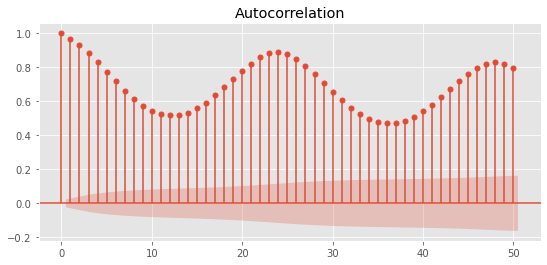

In [40]:
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 9, 4
# ACF function up to 50 lags
fig = plot_acf(deg_C["temperature"], lags=50)

plt.show();

The XAxis is the lag *k* and the YAxis is the Pearson's correlation coefficient at each lag. The red shaded region is a confidence interval. If the height of the bars are outside this region, it means the correlation is statistically significant.

## 2. What is white noise?

In short, white noise distribution is any distribution that has:

- zero mean
- a constant variance/standard deviation (does not change over time)
- zero autocorrelation at all lags

Essentially, it is a series of random numbers and by definition, no algorithm can reasonably model its behavior. 

There are special types of white noise. If the noise is normal (follows a [normal distribution](https://towardsdatascience.com/how-to-use-normal-distribution-like-you-know-what-you-are-doing-1cf4c55241e3?source=your_stories_page-------------------------------------)) it is called *Gaussian white noise*. Let's see an example of this visually:

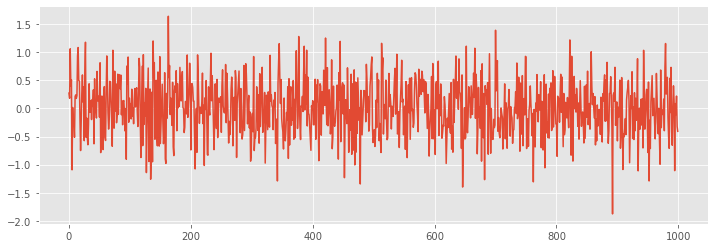

In [41]:
# Generate Gaussian white noise dist with mean 0 and 0.5 std
noise = np.random.normal(loc=0, scale=0.5, size=1000)

plt.figure(figsize=(12, 4))
plt.plot(noise);

> Gaussian white noise distribution with standard deviation of 0.5

Even though there are occasional spikes, there are no discernible patterns visible, i.e. the distribution is completely random.

The best way you can validate this is to create the ACF plot:

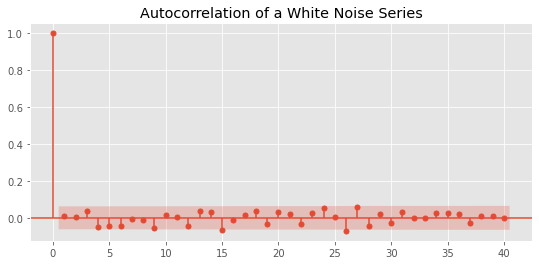

In [42]:
fig = plot_acf(noise, lags=40)

plt.title("Autocorrelation of a White Noise Series")
plt.show()

> White noise distributions have approximately 0 autocorrelation at all lags.

There are also "strict" white noise distributions - these have strictly 0 serial correlation. This is different from [brown/pink noise](https://en.wikipedia.org/wiki/Brownian_noise) or other natural random phenomena where there is a weak serial correlation but still remain memory-free. 

## 3. Importance of White Noise in Forecasting

Even though white noise distributions are considered dead ends, they can be quite useful in other contexts. 

For example, in time series forecasting, if the differences between predictions and actual values represent a white noise distribution, you can pat yourself on the back for a job well done.

When the residual errors show any type of pattern, whether seasonal or trending, or have non-zero mean, this suggests there is still room for improvement. In contrast, if the residuals are purely white noise, you maxed out the abilities of the chosen model. 

In other words, the algorithm managed to capture all the important signals and properties of the target. What's left are the random fluctuations and inconsistent data points that could not be attributed to anything.

As an example, we will predict the amount of carbon monoxide in the air using the July Kaggle playground competition. We will leave the inputs "as-is" - we won't perform any feature engineering and we will choose a baseline model with default parameters:

In [50]:
X = tps_july.drop(
    ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"], axis=1
)
y = tps_july["target_carbon_monoxide"].values.reshape(-1, 1)

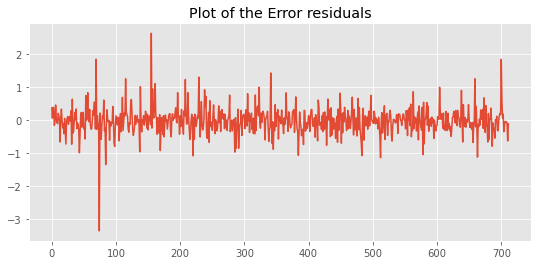

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1121218, test_size=0.1
)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

preds = forest.predict(X_test)
residuals = y_test.flatten() - preds

plt.plot(residuals)
plt.title("Plot of the Error residuals");

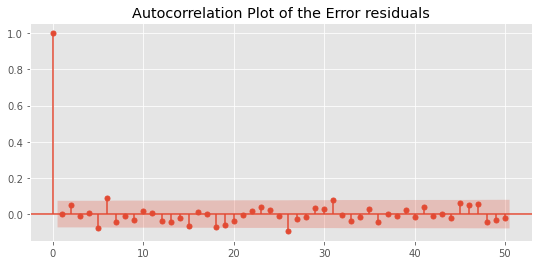

In [52]:
fig = plot_acf(residuals, lags=50)

plt.title("Autocorrelation Plot of the Error residuals")
plt.show();

There is some pattern in the ACF plot, but they are within the CI. These two plots suggest that even with default parameters, Random Forests could capture almost all the important signals from the training data.